<a href="https://colab.research.google.com/github/rajvirvyas/Senior-Project/blob/main/Senior_Project_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGLE_USR"] = userdata.get('KAGGLE_USR')

In [3]:
!kaggle datasets download -d marcozuppelli/stegoimagesdataset

! unzip -qq "stegoimagesdataset.zip"

Dataset URL: https://www.kaggle.com/datasets/marcozuppelli/stegoimagesdataset
License(s): DbCL-1.0
100% 1.51G/1.51G [01:12<00:00, 24.8MB/s]
100% 1.51G/1.51G [01:12<00:00, 22.5MB/s]


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt

def weighted_bce(y_true, y_pred):
    bce = BinaryCrossentropy()
    loss = bce(y_true, y_pred)
    stego_weight = 2.0  # Penalize missing stego images more
    weighted_loss = tf.where(y_true == 1, loss * stego_weight, loss)
    return tf.reduce_mean(weighted_loss)

custom_objects = {'weighted_bce': weighted_bce}

def create_custom_cnn(input_shape=(512, 512, 3)):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu',
               input_shape=input_shape,
                padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=1e-3),
                 loss=weighted_bce,
                 metrics=['accuracy'])
    return model

def create_data_generators(train_dir, val_dir, batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=(0.95, 1.05),  # Subtle changes
        channel_shift_range=2  # Slight color shifts
    )
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=(512, 512), batch_size=batch_size, class_mode='binary')
    val_generator = val_datagen.flow_from_directory(
        val_dir, target_size=(512, 512), batch_size=batch_size, class_mode='binary')

    return train_generator, val_generator

def compute_class_weights(generator):
    class_counts = [0] * len(generator.class_indices)
    for i in range(len(generator.classes)):
        class_counts[generator.classes[i]] += 1

    total_samples = sum(class_counts)
    class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}
    return class_weights

def train_steg_detector(model, train_generator, val_generator, epochs=10):
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    early_stop = EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)
    class_weights = compute_class_weights(train_generator)

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[reduce_lr, early_stop],
        class_weight=class_weights
    )
    return history

def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Train and evaluate
model = create_custom_cnn()
#model.summary()

# train_generator, val_generator = create_data_generators('/content/train/train', '/content/val/val')
# history = train_steg_detector(model, train_generator, val_generator)
# plot_history(history)


model.save('steg_detector_cnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
import shutil
shutil.rmtree('/content/test/test/stego_b64', ignore_errors=True) #some unnecessary 'classes'
shutil.rmtree('/content/test/test/stego_zip', ignore_errors=True)

In [18]:
def evaluate_model(model, test_dir, batch_size=32):
    loaded_model = tf.keras.models.load_model(model, custom_objects=custom_objects)
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir, target_size=(512, 512), batch_size=batch_size, class_mode='binary', shuffle=False)

    loss, accuracy = loaded_model.evaluate(test_generator)
    print(f'Test Loss: {loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')

    y_pred = loaded_model.predict(test_generator)
    y_true = test_generator.classes

    return y_true, y_pred


In [19]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_evaluation_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred > 0.5)  # Use 0.5 as my threshold for binary classification
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1], ['Clean', 'Stego'])
    plt.yticks([0, 1], ['Clean', 'Stego'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()


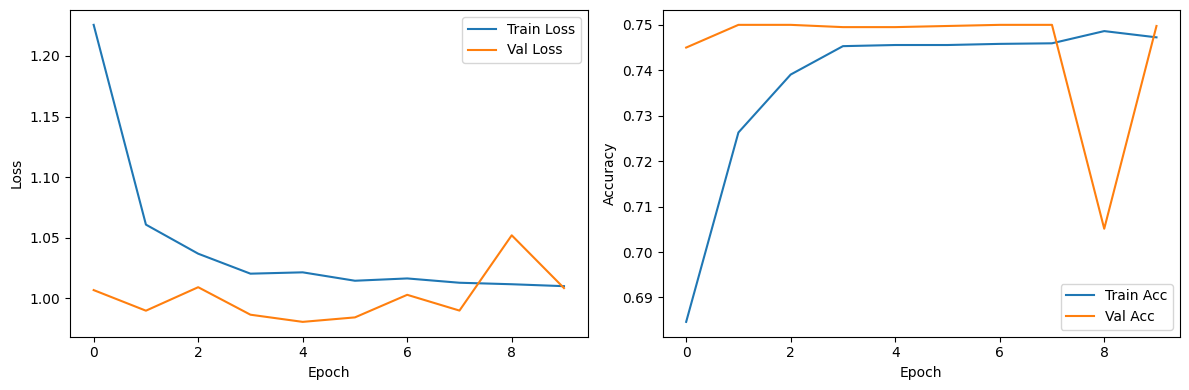

Found 8000 images belonging to 2 classes.
250/250 [==============================] - 68s 270ms/step - loss: 1.1999 - accuracy: 0.6026
Test Loss: 1.1999
Test Accuracy: 0.6026
250/250 [==============================] - 68s 271ms/step


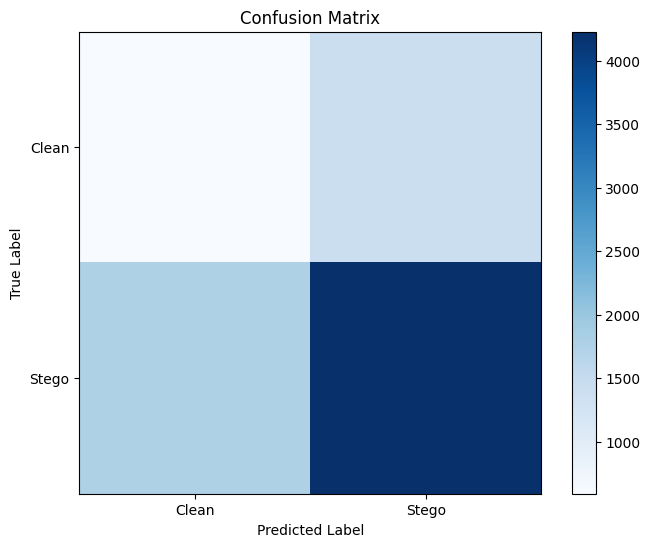

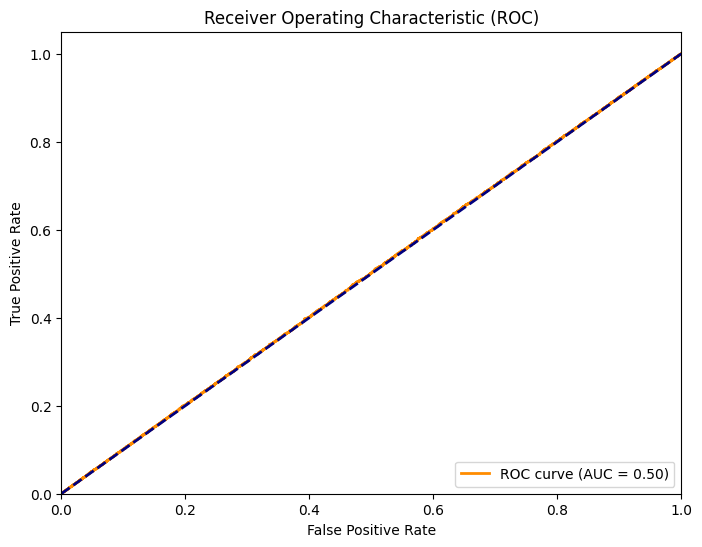

In [20]:
plot_history(history)

test_dir = '/content/test/test'
y_true, y_pred = evaluate_model('steg_detector_cnn.h5', test_dir)

plot_evaluation_metrics(y_true, y_pred)

In [28]:
import shutil
shutil.rmtree('/content/train/train/0', ignore_errors=True) #unecessary hidden folders
shutil.rmtree('/content/val/val/0', ignore_errors=True)
# shutil.rmtree('/content/val/val/0', ignore_errors=True)

In [ ]:
def evaluate_on_noisy_data(model, test_dir, noise_ratio=1.0):
    test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=lambda img: apply_noise(img, generate_time_series(img.shape[0] * img.shape[1])))
    test_generator = test_datagen.flow_from_directory(
        test_dir, target_size=(512, 512), batch_size=32, class_mode='binary', shuffle=False)

    results = model.evaluate(test_generator)
    print(f"Test loss (noisy): {results[0]}")
    print(f"Test accuracy (noisy): {results[1]}")


evaluate_on_noisy_data(model, '/content/test/test')

In [33]:
import os
import shutil
import random

def create_data_subset(src_dir, dst_dir, fraction=0.1):
    for class_name in os.listdir(src_dir):
        src_class_dir = os.path.join(src_dir, class_name)
        dst_class_dir = os.path.join(dst_dir, class_name)

        if not os.path.exists(dst_class_dir):
            os.makedirs(dst_class_dir)

        image_files = [f for f in os.listdir(src_class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))] # they may all just be pngs?
        num_to_copy = int(len(image_files) * fraction)

        for image in random.sample(image_files, num_to_copy):
            shutil.copy2(os.path.join(src_class_dir, image), os.path.join(dst_class_dir, image))

    print(f"made subset of data in {dst_dir}")

In [34]:
# Creating subsets of data
create_data_subset('/content/train/train', '/content/train_subset/train', fraction=0.1)
create_data_subset('/content/val/val', '/content/val_subset/val', fraction=0.1)

Created subset of data in /content/train_subset/train
Created subset of data in /content/val_subset/val


In [35]:
create_data_subset('/content/test/test', '/content/test_subset/test', fraction=0.1)

Created subset of data in /content/test_subset/test


In [ ]:
#implementing noisy training
def logistic_map(x, r):
    return r * x * (1 - x)

def generate_time_series(size, r=3.99, seed=0.5):
    x = seed
    time_series = [x]
    for _ in range(size - 1):
        x = logistic_map(x, r)
        x = (x - np.floor(x))
        time_series.append(x)
    return np.array(time_series)

def apply_noise(image, noisy_time_series):
    noisy_image = image.copy()
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(image.shape[2]):
                pixel_value = image[i, j, k]
                magic_num = noisy_time_series[(i * image.shape[1] + j) % len(noisy_time_series)]
                noisy_image[i, j, k] = np.clip(pixel_value + magic_num * 0.1, 0, 1)
    return noisy_image

def create_data_generators(train_dir, val_dir, test_dir,batch_size=32, noise_ratio=0.5):
    def noisy_preprocessing(img):
        if np.random.rand() < noise_ratio:
            noisy_time_series = generate_time_series(img.shape[0] * img.shape[1])
            return apply_noise(img, noisy_time_series)
        return img

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=(0.95, 1.05),
        channel_shift_range=2,
        preprocessing_function=noisy_preprocessing
    )
    val_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=noisy_preprocessing
    )
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=(0.95, 1.05),
        channel_shift_range=2,
        preprocessing_function=noisy_preprocessing
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=(512, 512), batch_size=batch_size, class_mode='binary')
    val_generator = val_datagen.flow_from_directory(
        val_dir, target_size=(512, 512), batch_size=batch_size, class_mode='binary')
    test_generator = test_datagen.flow_from_directory(
        test_dir, target_size=(512, 512), batch_size=batch_size, class_mode='binary')

    return train_generator, val_generator, test_generator

# Train and evaluate on subset
model = create_custom_cnn()

train_generator, val_generator, test_generator = create_data_generators('/content/train_subset/train', '/content/val_subset/val', '/content/test_subset/test', noise_ratio=0.5)
history = train_steg_detector(model, train_generator, val_generator, epochs=5)
plot_history(history)

model.save('steg_detector_cnn_subset_with_noise.h5') #taking forever

Found 1280 images belonging to 2 classes.
Found 640 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/5
 2/40 [>.............................] - ETA: 1:11:15 - loss: 12.2085 - accuracy: 0.4688

Found 16000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Epoch 1/10
500/500 [==============================] - 533s 1s/step - loss: 1.2318 - accuracy: 0.6833 - val_loss: 1.3375 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 586s 1s/step - loss: 1.0612 - accuracy: 0.7300 - val_loss: 1.0275 - val_accuracy: 0.7490 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 536s 1s/step - loss: 1.0335 - accuracy: 0.7391 - val_loss: 0.9949 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/10
500/500 [==============================] - 530s 1s/step - loss: 1.0212 - accuracy: 0.7438 - val_loss: 1.0061 - val_accuracy: 0.7467 - lr: 0.0010
Epoch 5/10
500/500 [==============================] - 536s 1s/step - loss: 1.0135 - accuracy: 0.7476 - val_loss: 0.9902 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/10
500/500 [==============================] - 523s 1s/step - loss: 1.0141 - accuracy: 0.7464 - val_loss: 0.9866 - val_accuracy:

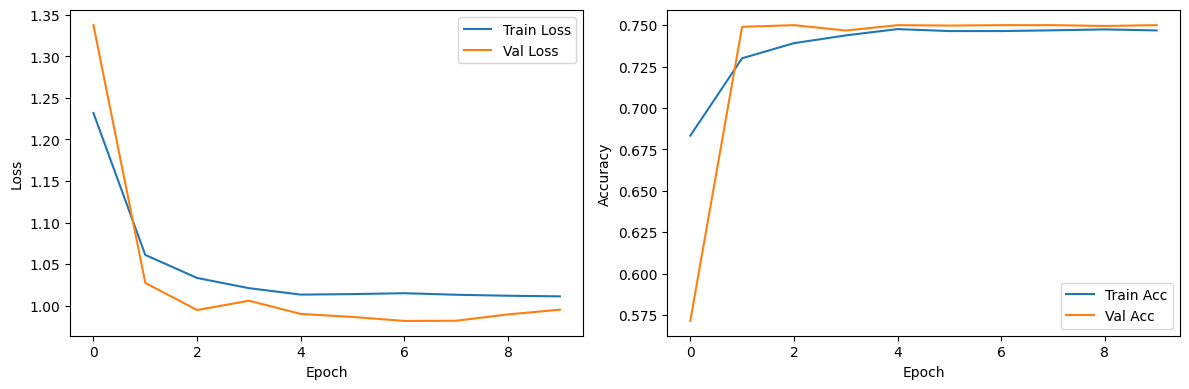

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt

def weighted_bce(y_true, y_pred):
    bce = BinaryCrossentropy()
    loss = bce(y_true, y_pred)
    stego_weight = 2.0  # Penalize missing stego images more
    weighted_loss = tf.where(y_true == 1, loss * stego_weight, loss)
    return tf.reduce_mean(weighted_loss)

def create_custom_cnn(input_shape=(512, 512, 3)):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # output: 256x256x16

        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # output: 128x128x32

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # output: 64x64x64

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # output: 32x32x64

        Flatten(),  # output: 32*32*64 = 65536
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=1e-3),
                 loss=weighted_bce,
                 metrics=['accuracy'])
    return model

def create_data_generators(train_dir, val_dir, batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=(0.95, 1.05),  # Subtle changes
        channel_shift_range=2  # Slight color shifts
    )
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=(512, 512), batch_size=batch_size, class_mode='binary')
    val_generator = val_datagen.flow_from_directory(
        val_dir, target_size=(512, 512), batch_size=batch_size, class_mode='binary')

    return train_generator, val_generator

def compute_class_weights(generator):
    class_counts = [0] * len(generator.class_indices)
    for i in range(len(generator.classes)):
        class_counts[generator.classes[i]] += 1

    total_samples = sum(class_counts)
    class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}
    return class_weights

def train_steg_detector(model, train_generator, val_generator, epochs=10):
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    class_weights = compute_class_weights(train_generator)

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[reduce_lr, early_stop],
        class_weight=class_weights
    )
    return history

def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Train and evaluate
model = create_custom_cnn()
#model.summary()

train_generator, val_generator = create_data_generators('/content/train/train', '/content/val/val')
history = train_steg_detector(model, train_generator, val_generator)
plot_history(history)

model.save('steg_detector_cnn.h5')

done